# Capstone Project: The Battle of Neighborhoods in Beijing: Restaurants

#### Packages needed

In [1]:
!conda install -c conda-forge geopy --yes 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install bs4
from bs4 import BeautifulSoup

!pip install html5lib
import html5lib

!pip install lxml
import lxml

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### List of counties in China on the wikipedia website. In this step, we will have the entire table ready as a data frame in python. 

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_counties_in_China").text
soup = BeautifulSoup(source, "html.parser")

table = soup.find("table",{'class':"wikitable"})
# Dataframe with 3 columns

df = pd.read_html(str(table))
df = pd.DataFrame(df[0])
df.head()

,Name,Prefecture,Province,Type,Population Census 2010
0,Yaohai,Hefei,Anhui,District,902830
1,Luyang,Hefei,Anhui,District,609239
2,Shushan,Hefei,Anhui,District,1022321
3,Baohe,Hefei,Anhui,District,817686
4,Changfeng,Hefei,Anhui,County,629535


#### Next, we will clean the data, having all the needed data. We will only need the districts which have more than 1 million population in Beijing. 

In [3]:
df = df[df['Province'] == 'Beijing']
df = df.drop(df.index[[-1,-2]])
df['Population Census 2010']=pd.to_numeric(df['Population Census 2010'] )
df = df[df['Population Census 2010'] > 1000000]
df

,Name,Prefecture,Province,Type,Population Census 2010
107,Xicheng,Directly administered,Beijing,District,1243000
108,Chaoyang,Directly administered,Beijing,District,3545000
109,Haidian,Directly administered,Beijing,District,3281000
110,Fengtai,Directly administered,Beijing,District,2112000
112,Tongzhou,Directly administered,Beijing,District,1184000
114,Changping,Directly administered,Beijing,District,1661000
115,Daxing,Directly administered,Beijing,District,1365000


#### This csv file contains the latitude and longitude coordinates for the selected districts in Beijing. 

In [4]:
df_geo_coor = pd.read_csv('Coor.csv')  
df_geo_coor

,District,Latitude,Longitude
0,Xicheng,39.9123,116.3659
1,Chaoyang,39.9215,116.4431
2,Haidian,39.9600,116.2983
3,Fengtai,39.8584,116.2871
4,Tongzhou,39.9099,116.6564
5,Changping,40.2207,116.2312
6,Daxing,39.7269,116.3414


#### Merge the coordinates to the original data frame with columns Latitude and Longitude. 

In [5]:
df = pd.merge(df, df_geo_coor, how='left', left_on = 'Name', right_on = 'District')
# remove the "District" column
df.drop("District", axis=1, inplace=True)
df

,Name,Prefecture,Province,Type,Population Census 2010,Latitude,Longitude
0,Xicheng,Directly administered,Beijing,District,1243000,39.9123,116.3659
1,Chaoyang,Directly administered,Beijing,District,3545000,39.9215,116.4431
2,Haidian,Directly administered,Beijing,District,3281000,39.9600,116.2983
3,Fengtai,Directly administered,Beijing,District,2112000,39.8584,116.2871
4,Tongzhou,Directly administered,Beijing,District,1184000,39.9099,116.6564
5,Changping,Directly administered,Beijing,District,1661000,40.2207,116.2312
6,Daxing,Directly administered,Beijing,District,1365000,39.7269,116.3414


#### Geodata preparation

In [6]:
address = 'Beijing'

geolocator = Nominatim(user_agent="Beijing_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Beijing are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Beijing are 39.9020803, 116.7185213.


#### create map

In [7]:
# create map of Beijing using latitude and longitude values
map_Beijing = folium.Map(location=[latitude, longitude], zoom_start=10)

 # add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Beijing) 
    
map_Beijing

#### Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'G3O3GAU45YMZMSUD2CSZAAHJV2WQRNCFE1OX4ETM3EOEMUNZ' # your Foursquare ID
CLIENT_SECRET = 'WIWWRNVAD4KDV5OMRBLDWHLUZWUYEBKHOFAEQHFXP1BLZHJF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G3O3GAU45YMZMSUD2CSZAAHJV2WQRNCFE1OX4ETM3EOEMUNZ
CLIENT_SECRET:WIWWRNVAD4KDV5OMRBLDWHLUZWUYEBKHOFAEQHFXP1BLZHJF


#### Using the Foursquare Location data to find neighborhoods in the first district: Xicheng

In [9]:
df.loc[0, 'Name']
neighborhood_latitude = df.loc[0, 'Latitude'] 
neighborhood_longitude = df.loc[0, 'Longitude'] 

neighborhood_name = df.loc[0, 'Name'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Xicheng are 39.9123, 116.3659.


In [10]:
LIMIT = 100

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=G3O3GAU45YMZMSUD2CSZAAHJV2WQRNCFE1OX4ETM3EOEMUNZ&client_secret=WIWWRNVAD4KDV5OMRBLDWHLUZWUYEBKHOFAEQHFXP1BLZHJF&v=20180605&ll=39.9123,116.3659&radius=500&limit=100'

In [11]:
results = requests.get(url).json()

#### function that extracts the category of the venue

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,西单商场 Xidan Shopping Center,Shopping Mall,39.909171,116.368074
1,Galeries Lafayette (老佛爷百货),Department Store,39.912724,116.367622
2,Din Tai Fung (鼎泰丰),Dumpling Restaurant,39.908116,116.367426
3,Haidilao Hot Pot (海底捞火锅),Hotpot Restaurant,39.913038,116.366899
4,Starbucks (星巴克),Coffee Shop,39.912476,116.367476


In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print ('{} unique categories in Xicheng'.format(nearby_venues['categories'].value_counts().shape[0]))
print (nearby_venues['categories'].value_counts()[0:10])

25 venues were returned by Foursquare.
17 unique categories in Xicheng
Department Store        3
Pizza Place             2
Szechuan Restaurant     2
Shopping Mall           2
Fast Food Restaurant    2
Clothing Store          2
Coffee Shop             2
Cantonese Restaurant    1
Hotpot Restaurant       1
Asian Restaurant        1
Name: categories, dtype: int64


#### Explore Neighborhoods in main districts of Beijing

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [16]:
Beijing_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Xicheng
Chaoyang
Haidian
Fengtai
Tongzhou
Changping
Daxing


In [17]:
# Create DataFrame for restaurants 
Beijing_Venues_only_restaurant = Beijing_venues[Beijing_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Beijing_Venues_only_restaurant.index = np.arange(1, len(Beijing_Venues_only_restaurant )+1)

In [18]:
print('There are {} uniques categories.'.format(len(Beijing_Venues_only_restaurant['Venue Category'].unique())))

There are 16 uniques categories.


In [19]:
# create a dataframe of top 10 categories
Beijing_5_Dist_Venues_Top10 = Beijing_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Beijing_5_Dist_Venues_Top10=Beijing_5_Dist_Venues_Top10.reset_index()

#Beijing_5_Dist_Venues_Top10
Beijing_5_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Beijing_5_Dist_Venues_Top10

,Venue_Category,Frequency
0,Fast Food Restaurant,7
1,Chinese Restaurant,5
2,Szechuan Restaurant,2
3,Cantonese Restaurant,2
4,Japanese Restaurant,2
5,Dumpling Restaurant,2
6,Sushi Restaurant,2
7,Ramen Restaurant,2
8,Asian Restaurant,1
9,Hotpot Restaurant,1


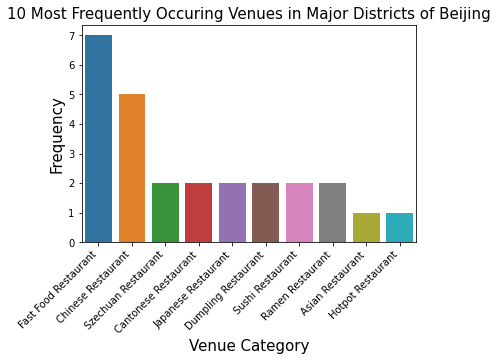

<Figure size 1296x504 with 0 Axes>

In [20]:
!pip install seaborn
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Beijing_5_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in Major Districts of Beijing', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [21]:
Beijing_Venues_only_restaurant.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Xicheng,39.9123,116.3659,Din Tai Fung (鼎泰丰),39.908116,116.367426,Dumpling Restaurant
2,Xicheng,39.9123,116.3659,Haidilao Hot Pot (海底捞火锅),39.913038,116.366899,Hotpot Restaurant
3,Xicheng,39.9123,116.3659,麻辣诱惑 Spice Spirit,39.908690,116.366648,Szechuan Restaurant
4,Xicheng,39.9123,116.3659,Yuxin Sichuan Cuisine (渝信川菜),39.912034,116.367623,Szechuan Restaurant
5,Xicheng,39.9123,116.3659,Bellagio (鹿港小镇),39.909638,116.366633,Taiwanese Restaurant
6,Xicheng,39.9123,116.3659,McDonald's (麦当劳),39.910243,116.367594,Fast Food Restaurant
7,Xicheng,39.9123,116.3659,McDonald's (麦当劳),39.909026,116.368162,Fast Food Restaurant
8,Xicheng,39.9123,116.3659,雕爷牛腩,39.912996,116.368041,Asian Restaurant
9,Xicheng,39.9123,116.3659,港丽餐厅,39.909012,116.367381,Cantonese Restaurant
10,Xicheng,39.9123,116.3659,Hakata Ikkousha (博多一幸舍),39.909528,116.366806,Ramen Restaurant


In [22]:
Beijing_Venues_restaurant = Beijing_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Beijing_Venues_restaurant

Neighborhood
Changping     1
Chaoyang     16
Fengtai       3
Tongzhou      2
Xicheng      10
Name: Venue Category, dtype: int64

In [23]:
Beijing_Venues_restaurant_df  = Beijing_Venues_restaurant.to_frame().reset_index()
Beijing_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Beijing_Venues_restaurant_df.index = np.arange(1, len(Beijing_Venues_restaurant_df)+1)
list_rest_no =Beijing_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =Beijing_Venues_restaurant_df['Neighborhood'].to_list()

### Analyze Each Neighborhood

In [24]:
# one hot encoding
Beijing_onehot = pd.get_dummies(Beijing_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Beijing_onehot['Neighborhood'] = Beijing_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Beijing_onehot.columns[-1]] + list(Beijing_onehot.columns[:-1])
Beijing_onehot = Beijing_onehot[fixed_columns]

Beijing_onehot.head()

,Neighborhood,Asian Restaurant,Beijing Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,Fast Food Restaurant,Hotpot Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Ramen Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant
1,Xicheng,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Xicheng,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Xicheng,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Xicheng,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,Xicheng,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Beijing_grouped = Beijing_onehot.groupby('Neighborhood').mean().reset_index()
Beijing_grouped

,Neighborhood,Asian Restaurant,Beijing Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,Fast Food Restaurant,Hotpot Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Ramen Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant
0,Changping,0.0,0.0000,0.0000,0.000000,0.000000,0.0000,1.0000,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0,0.0
1,Chaoyang,0.0,0.0625,0.0625,0.125000,0.000000,0.0625,0.1875,0.0,0.0625,0.125,0.0625,0.0625,0.0625,0.125,0.0,0.0
2,Fengtai,0.0,0.0000,0.0000,0.666667,0.333333,0.0000,0.0000,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0,0.0
3,Tongzhou,0.0,0.0000,0.0000,0.500000,0.000000,0.0000,0.5000,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0,0.0
4,Xicheng,0.1,0.0000,0.1000,0.000000,0.000000,0.1000,0.2000,0.1,0.0000,0.000,0.0000,0.0000,0.1000,0.000,0.2,0.1


In [26]:
num_top_venues = 5

for hood in Beijing_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Beijing_grouped[Beijing_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Changping----
                  venue  freq
0  Fast Food Restaurant   1.0
1      Asian Restaurant   0.0
2    Beijing Restaurant   0.0
3  Cantonese Restaurant   0.0
4    Chinese Restaurant   0.0


----Chaoyang----
                  venue  freq
0  Fast Food Restaurant  0.19
1    Chinese Restaurant  0.12
2   Japanese Restaurant  0.12
3      Sushi Restaurant  0.12
4    Beijing Restaurant  0.06


----Fengtai----
                     venue  freq
0       Chinese Restaurant  0.67
1  Comfort Food Restaurant  0.33
2         Asian Restaurant  0.00
3       Beijing Restaurant  0.00
4     Cantonese Restaurant  0.00


----Tongzhou----
                  venue  freq
0    Chinese Restaurant   0.5
1  Fast Food Restaurant   0.5
2      Asian Restaurant   0.0
3    Beijing Restaurant   0.0
4  Cantonese Restaurant   0.0


----Xicheng----
                  venue  freq
0  Fast Food Restaurant   0.2
1   Szechuan Restaurant   0.2
2      Asian Restaurant   0.1
3  Cantonese Restaurant   0.1
4   Dumpling Restaur

#### Check the 10 most common venues in each neighborhood.

In [27]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Beijing_grouped['Neighborhood']

for ind in np.arange(Beijing_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Beijing_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Changping,Fast Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Hotpot Restaurant
1,Chaoyang,Fast Food Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Italian Restaurant,Dumpling Restaurant,Cantonese Restaurant
2,Fengtai,Chinese Restaurant,Comfort Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
3,Tongzhou,Fast Food Restaurant,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
4,Xicheng,Szechuan Restaurant,Fast Food Restaurant,Taiwanese Restaurant,Ramen Restaurant,Hotpot Restaurant,Dumpling Restaurant,Cantonese Restaurant,Asian Restaurant,Sushi Restaurant,New American Restaurant


#### Cluster Neighborhoods

In [29]:
# set number of clusters
kclusters = 3

Beijing_grouped_clustering = Beijing_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Beijing_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 2, 2, 0], dtype=int32)

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels2', kmeans.labels_)

Beijing_merged = df.drop([2,6])

Beijing_merged.rename(columns={'Name':'Neighborhood'}, inplace=True)

# merge Beijing_grouped with data to add latitude/longitude for each neighborhood
Beijing_merged = Beijing_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Beijing_merged # check columns

,Neighborhood,Prefecture,Province,Type,Population Census 2010,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Xicheng,Directly administered,Beijing,District,1243000,39.9123,116.3659,0,Szechuan Restaurant,Fast Food Restaurant,Taiwanese Restaurant,Ramen Restaurant,Hotpot Restaurant,Dumpling Restaurant,Cantonese Restaurant,Asian Restaurant,Sushi Restaurant,New American Restaurant
1,Chaoyang,Directly administered,Beijing,District,3545000,39.9215,116.4431,0,Fast Food Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Italian Restaurant,Dumpling Restaurant,Cantonese Restaurant
3,Fengtai,Directly administered,Beijing,District,2112000,39.8584,116.2871,2,Chinese Restaurant,Comfort Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
4,Tongzhou,Directly administered,Beijing,District,1184000,39.9099,116.6564,2,Fast Food Restaurant,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
5,Changping,Directly administered,Beijing,District,1661000,40.2207,116.2312,1,Fast Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Hotpot Restaurant


#### Visualize the resulting clusters

In [31]:
# create map
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Beijing_merged['Latitude'], 
                                  Beijing_merged['Longitude'], 
                                  Beijing_merged['Neighborhood'], 
                                  Beijing_merged['Cluster Labels2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

# Examine Clusters

#### Cluster 1

In [33]:
Beijing_merged.loc[Beijing_merged['Cluster Labels2'] == 0, Beijing_merged.columns[[1] + list(range(5, Beijing_merged.shape[1]))]]

,Prefecture,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Directly administered,39.9123,116.3659,0,Szechuan Restaurant,Fast Food Restaurant,Taiwanese Restaurant,Ramen Restaurant,Hotpot Restaurant,Dumpling Restaurant,Cantonese Restaurant,Asian Restaurant,Sushi Restaurant,New American Restaurant
1,Directly administered,39.9215,116.4431,0,Fast Food Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Italian Restaurant,Dumpling Restaurant,Cantonese Restaurant


#### Cluster 2

In [34]:
Beijing_merged.loc[Beijing_merged['Cluster Labels2'] == 1, Beijing_merged.columns[[1] + list(range(5, Beijing_merged.shape[1]))]]

,Prefecture,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Directly administered,40.2207,116.2312,1,Fast Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Hotpot Restaurant


#### Cluster 3

In [35]:
Beijing_merged.loc[Beijing_merged['Cluster Labels2'] == 2, Beijing_merged.columns[[1] + list(range(5, Beijing_merged.shape[1]))]]

,Prefecture,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Directly administered,39.8584,116.2871,2,Chinese Restaurant,Comfort Food Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
4,Directly administered,39.9099,116.6564,2,Fast Food Restaurant,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,New American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
